#####   1. Getting and preprocessing input data

If you have previously executed this step and downloaded all input data you can skip this step and proceed directly to step 2. However, if you are not sure, run step 1 and the model will either confirm that a specific data has aready been downloaded and subsequently viualize it or it will proceeed to download the data if it is not available or prior download was incomplete.

In [1]:
%cd /home/WUR/duku002/Scripts/drought_floods/vscode

/home/WUR/duku002/Scripts/drought_floods/vscode


In [2]:
working_dir='/lustre/backup/WUR/ESG/duku002/Drought-Flood-Cascade/niger'
study_area='/home/WUR/duku002/Scripts/NBAT/hydro/common_data/niger.shp'

     - Tree cover data already exists in /lustre/backup/WUR/ESG/duku002/Drought-Flood-Cascade/niger/vcf/mean_tree_cover.tif; skipping download.
     - Tree cover data already exists in /lustre/backup/WUR/ESG/duku002/Drought-Flood-Cascade/niger/vcf/mean_tree_cover.tif; skipping preprocessing.


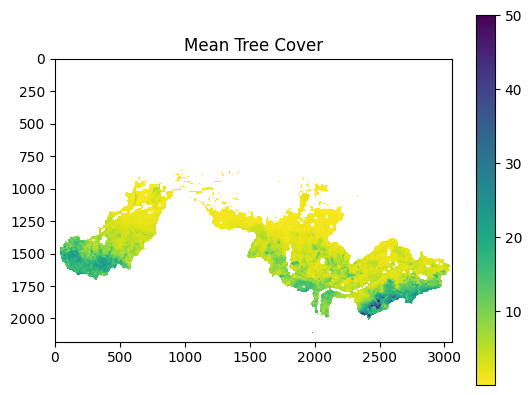

In [3]:

# download and preprocess MODIS vegetation continuous fields from Google Earth Engine Data catalog

from bakaano.tree_cover import TreeCover
vf = TreeCover(
    working_dir=working_dir, 
    study_area=study_area, 
    start_date='2001-01-01', 
    end_date='2020-12-31'
)
vf.get_tree_cover_data()
vf.plot_tree_cover(variable='tree_cover') # options for plot are 'tree_cover' and 'herb_cover'

     - NDVI data already exists in /lustre/backup/WUR/ESG/duku002/Drought-Flood-Cascade/niger/ndvi/daily_ndvi_climatology.pkl; skipping download.
     - NDVI data already exists in /lustre/backup/WUR/ESG/duku002/Drought-Flood-Cascade/niger/ndvi/daily_ndvi_climatology.pkl; skipping preprocessing.


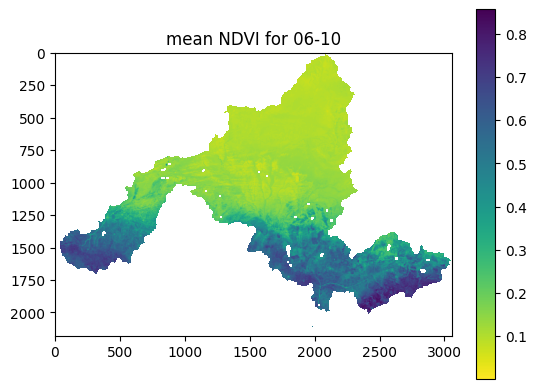

In [4]:
# download and preprocess MODIS NDVI data from Google Earth Engine Data catalog

from bakaano.ndvi import NDVI
nd = NDVI(
    working_dir=working_dir, 
    study_area=study_area, 
    start_date='2001-01-01', 
    end_date='2010-12-31'
)
nd.get_ndvi_data()
nd.plot_ndvi(interval_num=10)  # because NDVI is in 16-day interval the 'interval_num' represents a 16-day period. 
                               #Hence 0 is the first 16 day period

     - DEM data already exists in /lustre/backup/WUR/ESG/duku002/Drought-Flood-Cascade/niger/elevation; skipping download.


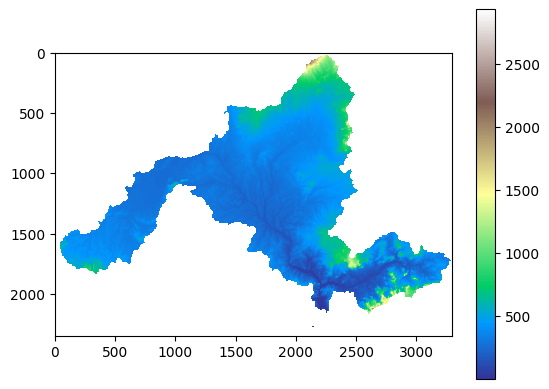

In [5]:
# Get elevation data

from bakaano.dem import DEM
dd = DEM(
    working_dir=working_dir, 
    study_area=study_area, 
    local_data=False, 
    local_data_path=None
)
dd.get_dem_data()
dd.plot_dem()

     - Soil data already exists in /lustre/backup/WUR/ESG/duku002/Drought-Flood-Cascade/niger/soil; skipping download.


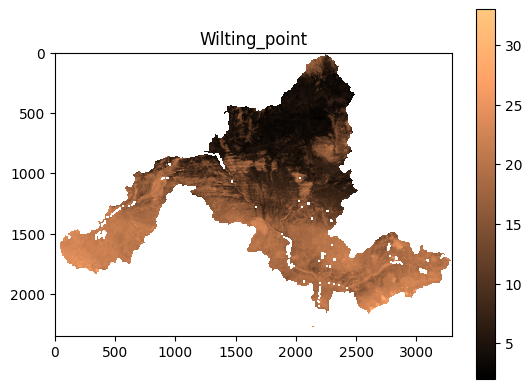

In [6]:
# Get soil data

from bakaano.soil import Soil
sgd = Soil(
    working_dir=working_dir, 
    study_area=study_area
)
sgd.get_soil_data()
sgd.plot_soil(variable='wilting_point')  #options are 'wilting_point', 'saturation_point' and 'available_water_content'

✓ All 64 AlphaEarth bands already downloaded. Skipping.


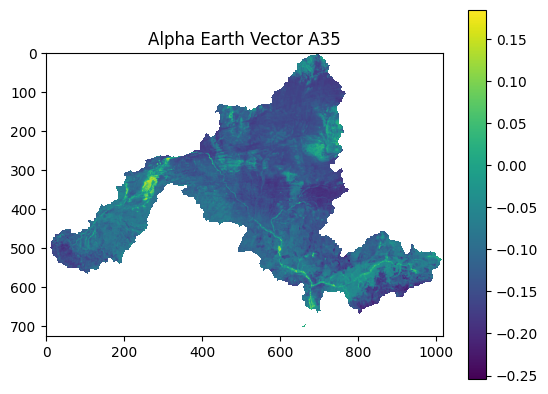

In [7]:
#  Get alpha earth satellite embedding dataset

from bakaano.alpha_earth import AlphaEarth
dd = AlphaEarth(
    working_dir=working_dir, 
    study_area=study_area,
    start_date='2013-01-01', 
    end_date = '2024-01-01',
)
dd.get_alpha_earth()
dd.plot_alpha_earth('A35') #Band options are A00 to A63

     - ERA5 Land daily data already exists in /lustre/backup/WUR/ESG/duku002/Drought-Flood-Cascade/niger/era5_land; skipping download.


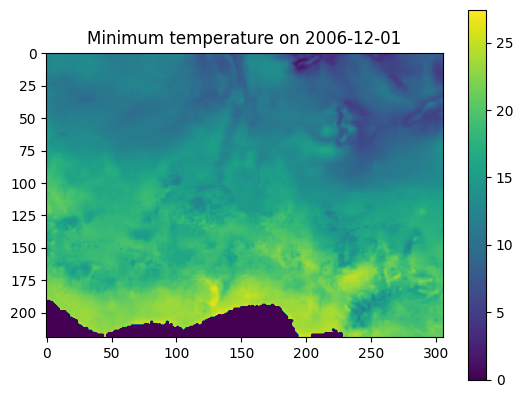

In [8]:
#get meteo

from bakaano.meteo import Meteo
cd = Meteo(
    working_dir=working_dir, 
    study_area=study_area, 
    start_date='2001-01-01', 
    end_date='2010-12-31',
    local_data=False, 
    data_source='ERA5'
)
cd.plot_meteo(variable='tasmin', date='2006-12-01') # variable options are 'tmean', 'precip', 'tasmax', 'tasmin'

#####   2. Computing runoff and routing to river network

In [9]:

from bakaano.veget import VegET
vg = VegET(
    working_dir=working_dir, 
    study_area=study_area,
    start_date='2001-01-01', 
    end_date='2010-12-31',
    climate_data_source='ERA5',
    routing_method='mfd'
)
vg.compute_veget_runoff_route_flow()

Routed runoff data exists in /lustre/backup/WUR/ESG/duku002/Drought-Flood-Cascade/niger/runoff_output/wacc_sparse_arrays.pkl. Skipping processing


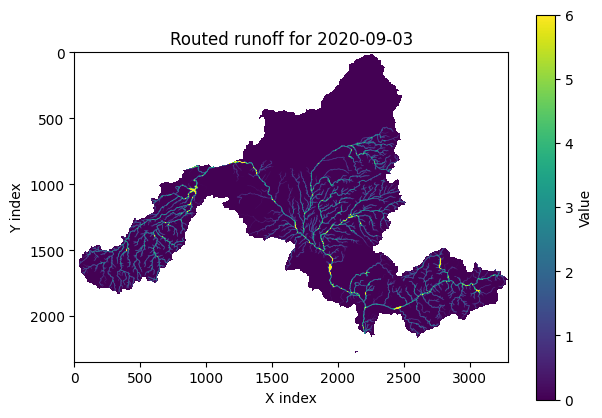

In [10]:
#visualize routed runoff data

from bakaano.plot_runoff import RoutedRunoff
rr = RoutedRunoff(
    working_dir=working_dir, 
    study_area=study_area
)
rr.map_routed_runoff(date='2020-09-03', vmax=6) #output values have been log transformed for better visualization

#####   3. Explore input data, river networks and hydrological stations interactively

In [11]:
from bakaano.runner import BakaanoHydro
bk = BakaanoHydro(
    working_dir=working_dir, 
    study_area=study_area,
    climate_data_source='ERA5'
)
bk.explore_data_interactively('1981-01-01', '2016-12-31', '/lustre/backup/WUR/ESG/duku002/NBAT/hydro/input_data/GRDC-Daily-africa-south-america.nc')

2025-12-18 13:11:20.637642: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766059880.648137   29599 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766059880.651224   29599 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


#####   4. Training, Evaluating and Applying Bakaano-Hydro model 

In [12]:
# INITIALIZE INSTANCE OF BAKAANO-HYDRO MODEL

from bakaano.runner import BakaanoHydro
bk = BakaanoHydro(  
    working_dir=working_dir, 
    study_area=study_area,
    climate_data_source='ERA5'
)

In [ ]:
# TRAINING BAKAANO-HYDRO MODEL

# The model is trained using the GRDC streamflow data.
# Note: The training process is computationally expensive and may take a long time to complete.
# trained model is always in the models folder in the working_dir and with a .keras extension
# the model names is always in the format: bakaano_model_<loss_fn>_<num_input_branch>_branches.keras

bk.train_streamflow_model(
    train_start='1991-01-01', 
    train_end='2020-12-31', 
    grdc_netcdf='/lustre/backup/WUR/ESG/duku002/NBAT/hydro/input_data/GRDC-Daily-africa-south-america.nc', 
    lookback=365, 
    batch_size=1024, 
    num_epochs=100
)

Available station names:
['AKKA' 'ALCONGUI' 'ANSONGO' 'BADEGUICHERI' 'BANANKORO' 'BARO' 'BAROU'
 'BENENY-KEGNY' 'BOUGOUNI' 'CAMPEMENT DU DOUBLE VE' 'COUBERI' 'DABOLA'
 'DEBETE' 'DIALAKORO' 'DIOILA' 'DIONGORE AMONT' 'DIRE' 'DJIRILA' 'DOLBEL'
 'DOUNA' 'FARANAH' 'GARBE-KOUROU' 'GOUALA' 'GOUNDAM' 'GOUNOU-GAYA'
 'GUELELINKORO' 'GUINDAM ROUMDJI' 'GUINGUERINI' 'IBI' 'IRADOUGOU'
 'KAKASSI' 'KANDADJI' 'KANKAN' 'KARA' 'KE-MACINA' 'KEROU' 'KEROUANE'
 'KIRANGO AVAL' 'KISSIDOUGOU' 'KLELA' 'KOLONDIEBA' 'KOMPONGOU'
 'KONSANKORO' 'KORYOUME' 'KOULIKORO' 'KOUORO 1' 'KOUORO 2' 'KOUROUSSA'
 'KOUTAKOUKROU' 'KOUTO AMONT' 'KOUTO AVAL' 'LOKOJA' 'MADAROUNFA'
 'MADINA DIASSA' 'MALANVILLE' 'MANANKORO' 'MANDIANA' 'MOLOKORO' 'MOPTI'
 'NANTAKA (MOPTI)' 'NIAMEY' 'NIELLOUA' 'OUARAN' 'PANKOUROU' 'PAPARA'
 'PONONDOUGOU' 'PONT CAROL' 'ROUTE KANDI-BANIKOARA AMONT'
 'ROUTE KANDI-BANIKOARA AVAL' 'RTE KANDI-SEGBANA AMONT'
 'RTE KANDI-SEGBANA AVAL' 'SAMATIGUILA' 'SARAFERE' 'SELINGUE' 'SOFARA'
 'TAMOU' 'TERA' 'TIGUIBERY' 'TIL

2025-12-18 13:29:04.706041: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step
Nash-Sutcliffe Efficiency (NSE): 0.7122612622507017
Kling-Gupta Efficiency (KGE): 0.7443427177596089


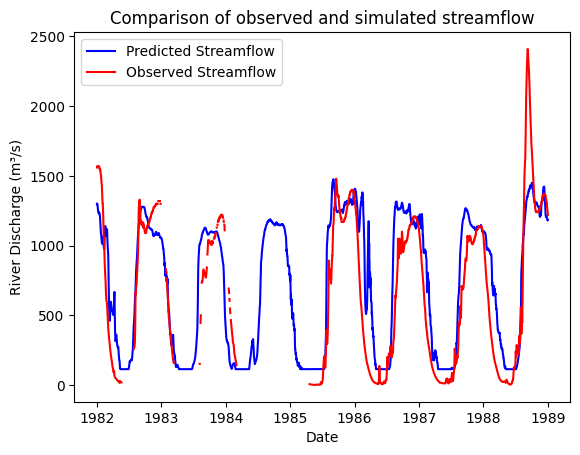

In [13]:
# EVALUATING THE TRAINED MODEL INTERACTIVELY

# The model is evaluated using the GRDC streamflow data.


# trained model is always in the models folder in the working_dir and with a .keras extension
# the model names is always in the format: bakaano_model_<loss_fn>_<num_input_branch>_branches.keras
model_path = f'{working_dir}/models/bakaano_model.keras' 

bk.evaluate_streamflow_model_interactively(
    model_path=model_path, 
    val_start='1981-01-01', 
    val_end='1988-12-31', 
    grdc_netcdf='/lustre/backup/WUR/ESG/duku002/NBAT/hydro/input_data/GRDC-Daily-africa-south-america.nc', 
    lookback=365
)

In [ ]:
# PREDICTING STREAMFLOW USING THE TRAINED MODEL AND STORING AS CSV FILES 
# The model is used to predict streamflow in any location in the study area. 

model_path = f'{working_dir}/models/bakaano_model.keras'

bk.simulate_streamflow(
    model_path=model_path, 
    sim_start='1981-01-01', 
    sim_end='1988-12-31', 
    latlist=[13.8, 13.9, 9.15, 8.75, 10.66, 9.32, 7.8, 8.76, 6.17],
    lonlist=[3.0, 4.0, 4.77, 5.91, 4.69, 4.63, 8.91, 10.82, 6.77],
    lookback=365
)
